In [1]:
!pip install simpletransformers

In [2]:
# import torch

import os
import math
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from scipy.special import softmax


from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [3]:
olid_url = 'https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/olid-train-small.csv'
olid_test_url = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/olid-test.csv"
hasoc_url = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/hasoc-train.csv"
hate_lexicon = "https://raw.githubusercontent.com/Mohammed-majeed/Subjectivity-Mining/main/Assignment%205%20-%20Group%2011/Datasets/expandedLexicon.txt"

In [4]:

# To make the output reproducible set seed to 42
# Set random seed for Python's random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

In [5]:
OLIDv1_train_df = (pd.read_csv(olid_url)).drop("id",axis = 1)  # length 5852
OLIDv1_test_df = (pd.read_csv(olid_test_url)).drop("id",axis = 1)         # length 860

hasoc_train_df = (pd.read_csv(hasoc_url)).drop("id",axis = 1)       # length 5852

lexicon_df = pd.read_csv(hate_lexicon, sep='\t', header=None, names=["word", "label"], encoding="utf-8")
lexicon_df['word'] = lexicon_df['word'].str.replace(r'_[a-zA-Z]+$', '', regex=True)


In [6]:
# Split the OLIDv1_train_df into input features and labels
X_olid = OLIDv1_train_df['text']
Y_olid = OLIDv1_train_df['labels']

# Split the hasoc_train_df into input features and labels
X_hasoc = hasoc_train_df['text']
Y_hasoc = hasoc_train_df['labels']

# Split the OLIDv1_train_df dataset into a training set and a validation set
X_train_olid, X_val_olid, Y_train_olid, Y_val_olid = train_test_split(X_olid, Y_olid, test_size=0.2, random_state=42)


train_olid = pd.concat([X_train_olid, Y_train_olid], axis=1)
val_olid = pd.concat([X_val_olid, Y_val_olid], axis=1)

# Split the hasoc_train_df dataset into a training set and a validation set
X_train_hasoc, X_val_hasoc, Y_train_hasoc, Y_val_hasoc = train_test_split(X_hasoc, Y_hasoc, test_size=0.2, random_state=42)

train_hasoc = pd.concat([X_train_hasoc, Y_train_hasoc], axis=1)
val_hasoc = pd.concat([X_val_hasoc, Y_val_hasoc], axis=1)

In [7]:
# print and plot confusion matrix
def print_and_plot_confusion_matrix(true_labels, predicted_labels, experiment_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    print(f'Confusion Matrix for {experiment_name}:')
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    # Adjust the font size for better visualization
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No hate', 'Hate'],
                yticklabels=['No hate', 'Hate'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {experiment_name}')
    plt.show()

In [8]:
# calculate and print classification report
def print_classification_report(true_labels, predicted_labels, experiment_name):
    report = classification_report(true_labels, predicted_labels)
    print(f'Classification Report for {experiment_name}:')
    print(report)

In [9]:
# def plot_losses(training_log,formatted_experiment_name):
#     plt.plot(training_log['train_loss'], label='training Loss')
#     plt.plot(training_log['eval_loss'], label='validation Loss')
#     plt.title('Training and validation loss over epochs \n'+formatted_experiment_name)
#     plt.xlabel('Evaluation Steps')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

# Transformer based models


In [10]:
from sklearn.model_selection import StratifiedKFold

def fine_tune_and_evaluate(experiment_name, train_dataset, val_dataset, test_dataset,
                           model_type, model_case, retrain=False, num_folds=1):
    best_model_directory = None
    model_directory = None
    if num_folds <= 1:
        # If num_folds is 1 or less, train and evaluate on the full training dataset without cross-validation
        model_directory = f"output/{model_type}/{model_case}/{experiment_name}"
        best_model_directory = model_directory + '/best_model'
    else:
        # Prepare k-fold cross-validation
        kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        model_directory = f"output/{model_type}/{model_case}/cv{num_folds}/{experiment_name}"
        best_model_directory = model_directory + '/best_model'

    # Initialize lists to store predictions from base models
    base_model_predictions = []

    model_arguments = ClassificationArgs(output_dir=model_directory,
                                      best_model_dir=best_model_directory,
                                      save_best_model=True,
                                      reprocess_input_data = True,
                                      overwrite_output_dir=True,
                                      no_cache=True,

                                      evaluate_during_training = True,
                                      evaluate_during_training_verbose = True,
                                    #  evaluate_during_training_steps = 120,
                                    #  use_cached_eval_features = True,
                                    #  save_eval_checkpoints = True,
                                      save_model_every_epoch = False,

                                      use_early_stopping = True,
                                      early_stopping_metric = "eval_loss",
                                      early_stopping_metric_minimize = True,
                                      early_stopping_patience = 2,
                                      early_stopping_delta = 0.01,

                                    #  learning_rate= 1e-6,
                                    #  num_train_epochs=5,
                                    #  train_batch_size=32,
                                    #  eval_batch_size=32,
                                      max_seq_length = 128
                                      )

    # Loop through the folds if using cross-validation
    if num_folds > 1:
        # Train or load the model based on the existence of the model directory
        if not os.path.exists(model_directory) or retrain:
            model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
            for train_index, val_index in kf.split(train_dataset.text, train_dataset.labels):
                train_fold, val_fold = train_dataset.iloc[train_index], train_dataset.iloc[val_index]
                model.train_model(train_fold, eval_df=val_fold)
        else:
            model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)

            # # Make predictions on the validation dataset for this fold
            # val_predictions, _ = model.predict(list(val_dataset.text))
            # base_model_predictions.append(val_predictions)

        # # Concatenate predictions from all folds for validation dataset
        # val_predictions = np.concatenate(base_model_predictions)

    else:
        # Train the model on the full training dataset without cross-validation
        # Train or load the model based on the existence of the model directory
        if not os.path.exists(model_directory) or retrain:
            model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
            model.train_model(train_dataset, eval_df=val_dataset)
        else:
            model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)

        # # Make predictions on the validation dataset (same as the test dataset for single-fold scenario)
        # val_predictions, _ = model.predict(list(val_dataset.text))

    # Make predictions on the test dataset
    test_predictions, test_probabilities = model.predict(list(test_dataset.text))

    # Calculate softmax probabilities for Soft Majority Voting
    softmax_probabilities = softmax(test_probabilities, axis=1)

    # Format the experiment name for display
    formatted_experiment_name = f'{model_type}" / "{model_case}" / "{experiment_name}'

    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Print classification report
    print_classification_report(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Return predictions and probabilities for ensembling
    return test_predictions, softmax_probabilities


======================
# xlnet
======================

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
[[543  77]
 [ 82 158]]


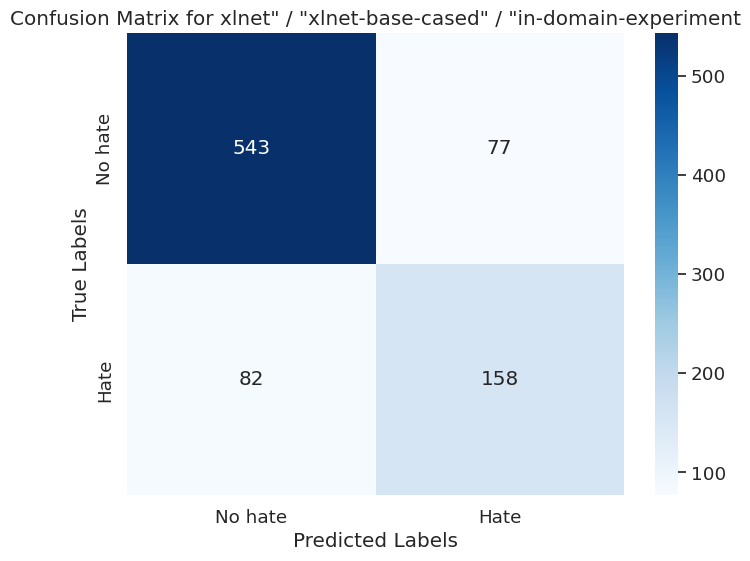

Classification Report for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       620
           1       0.67      0.66      0.67       240

    accuracy                           0.82       860
   macro avg       0.77      0.77      0.77       860
weighted avg       0.81      0.82      0.81       860



In [11]:
# Train and evaluate the model xlnet in-domain

xlnet_predictions, xlnet_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True, num_folds=1)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
[[557  63]
 [158  82]]


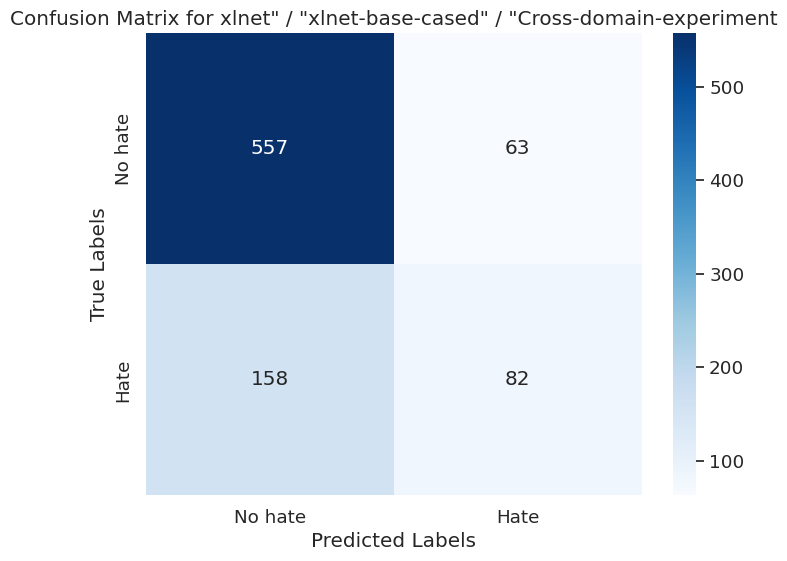

Classification Report for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       620
           1       0.57      0.34      0.43       240

    accuracy                           0.74       860
   macro avg       0.67      0.62      0.63       860
weighted avg       0.72      0.74      0.72       860



In [12]:
# Train and evaluate the model xlnet Cross-domain
cross_xlnet_predictions, cross_xlnet_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True)


======================
# hateBert
======================

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
[[581  39]
 [ 87 153]]


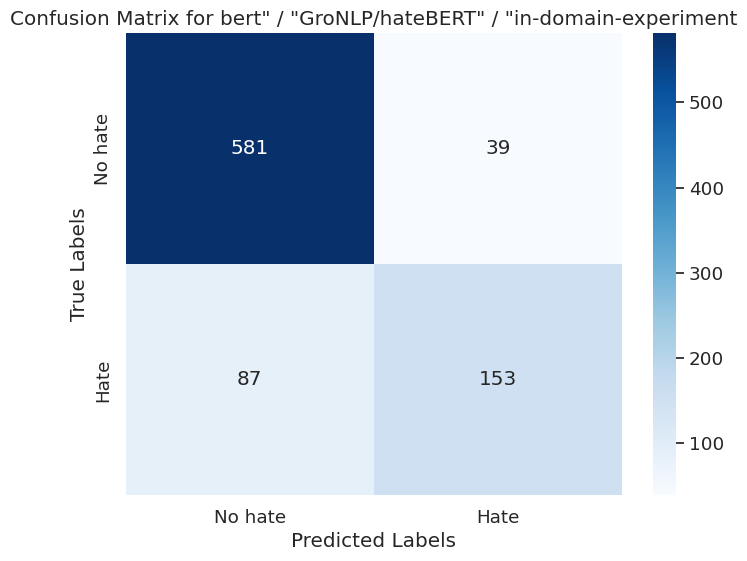

Classification Report for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       620
           1       0.80      0.64      0.71       240

    accuracy                           0.85       860
   macro avg       0.83      0.79      0.81       860
weighted avg       0.85      0.85      0.85       860



In [13]:
# Train and evaluate the model hateBert in-domain
hateBERT_predictions, hateBERT_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
[[559  61]
 [118 122]]


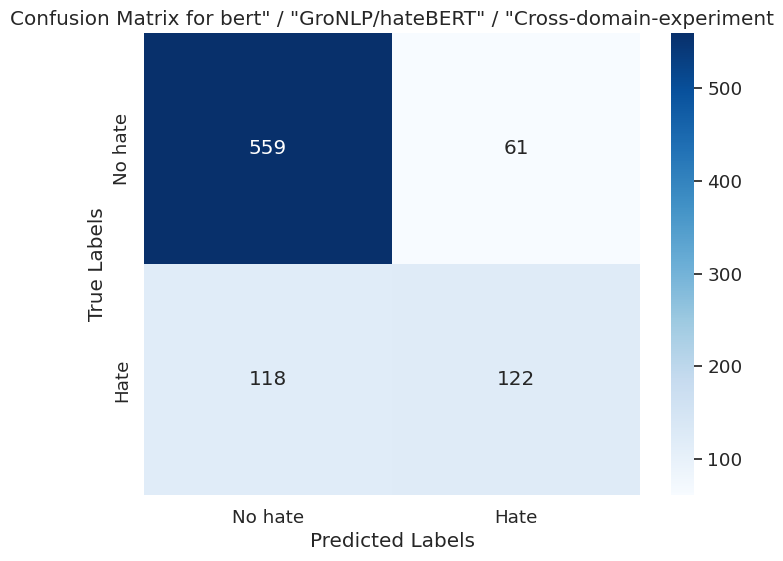

Classification Report for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       620
           1       0.67      0.51      0.58       240

    accuracy                           0.79       860
   macro avg       0.75      0.70      0.72       860
weighted avg       0.78      0.79      0.78       860



In [14]:
# Train and evaluate the model hateBert Cross-domain
cross_hateBERT_predictions, cross_hateBERT_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


======================
# Roberta model
======================

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "in-domain-experiment:
[[561  59]
 [ 78 162]]


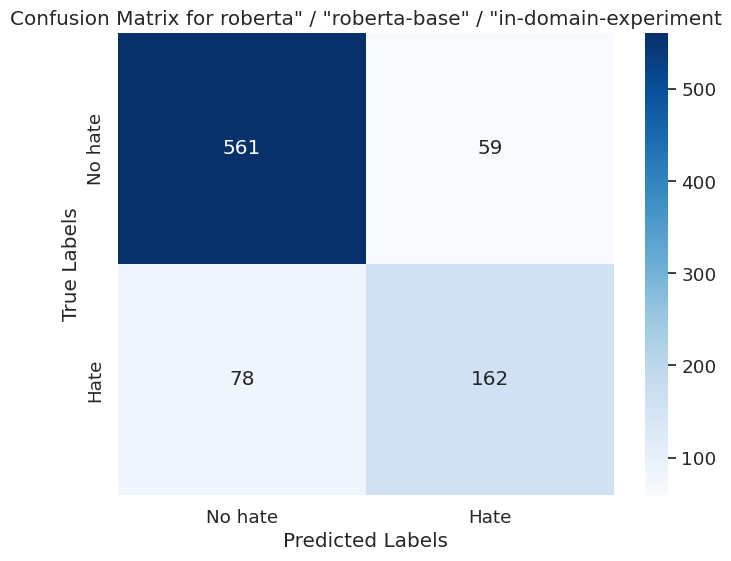

Classification Report for roberta" / "roberta-base" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       620
           1       0.73      0.68      0.70       240

    accuracy                           0.84       860
   macro avg       0.81      0.79      0.80       860
weighted avg       0.84      0.84      0.84       860



In [15]:
# Train and evaluate the model roberta in-domain

roberta_predictions, roberta_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4681 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/1171 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "Cross-domain-experiment:
[[558  62]
 [133 107]]


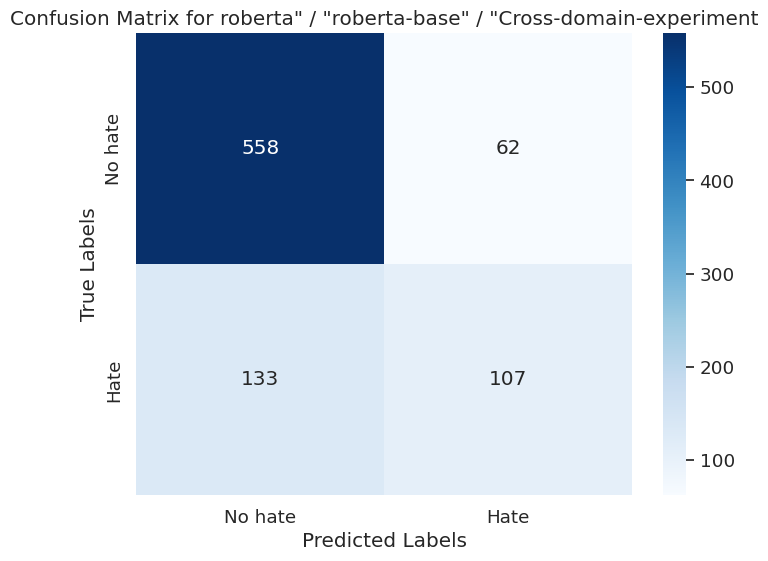

Classification Report for roberta" / "roberta-base" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       620
           1       0.63      0.45      0.52       240

    accuracy                           0.77       860
   macro avg       0.72      0.67      0.69       860
weighted avg       0.76      0.77      0.76       860



In [16]:
# Train and evaluate the model roberta Cross-domain

cross_roberta_predictions, cross_roberta_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                       train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True)


=================
# hard Majority Voting
=================

In [17]:
# Hard Majority Voting
def hard_majority_voting(predictions_list):
    # Stack the predictions vertically to get a matrix where each row represents predictions from a model
    stacked_predictions = np.vstack(predictions_list)
    # Calculate majority vote along each column
    majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=stacked_predictions)
    return majority_vote

Confusion Matrix for Hard Majority Voting in-domain:
[[580  40]
 [ 81 159]]


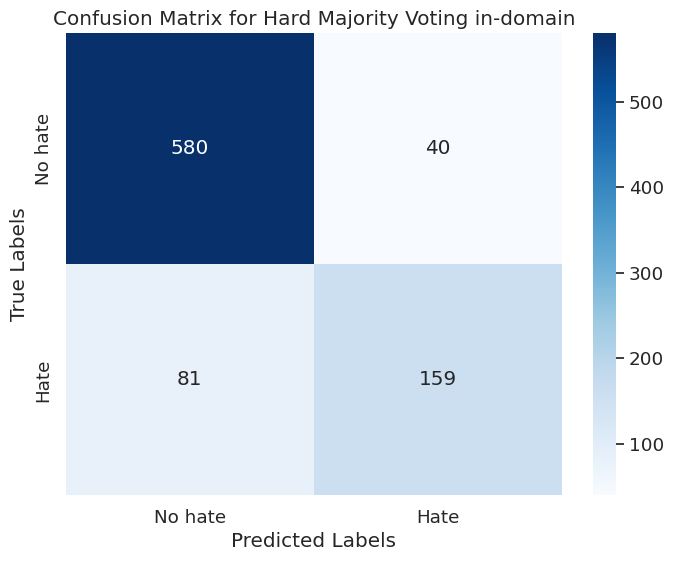

Classification Report for Hard Majority Voting in-domain:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       620
           1       0.80      0.66      0.72       240

    accuracy                           0.86       860
   macro avg       0.84      0.80      0.81       860
weighted avg       0.86      0.86      0.85       860



In [18]:
# Perform Hard Majority Voting in-domain

# Combine predictions from different models
hard_majority_predictions = hard_majority_voting([xlnet_predictions, hateBERT_predictions, roberta_predictions])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, hard_majority_predictions, "Hard Majority Voting in-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, hard_majority_predictions, "Hard Majority Voting in-domain")


Confusion Matrix for Hard Majority Voting cross-domain:
[[575  45]
 [136 104]]


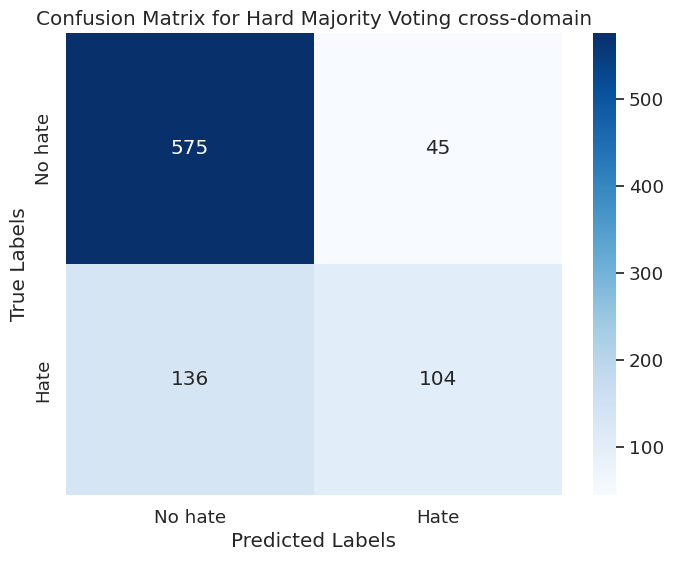

Classification Report for Hard Majority Voting cross-domain:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       620
           1       0.70      0.43      0.53       240

    accuracy                           0.79       860
   macro avg       0.75      0.68      0.70       860
weighted avg       0.78      0.79      0.77       860



In [19]:
# Perform Hard Majority Voting cross-domain

# Combine predictions from different models
cross_hard_majority_predictions = hard_majority_voting([cross_xlnet_predictions, cross_hateBERT_predictions, cross_roberta_predictions])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, cross_hard_majority_predictions, "Hard Majority Voting cross-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, cross_hard_majority_predictions, "Hard Majority Voting cross-domain")


=================
# Soft Majority Voting
=================

In [20]:
# Soft Majority Voting
def soft_majority_voting(probabilities_list):
    # Add all arrays element-wise
    sum_arrays = np.sum(probabilities_list, axis=0)
    # Calculate the average
    average_array = sum_arrays / 3
    # Get the index of the maximum value in the average array
    final_prediction = np.argmax(average_array, axis=1)
    return final_prediction

Confusion Matrix for Soft Majority Voting in-domain:
[[579  41]
 [ 80 160]]


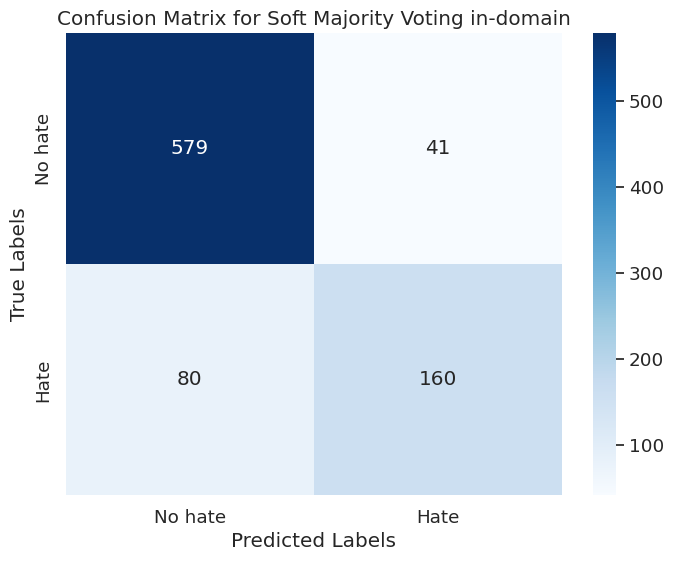

Classification Report for Soft Majority Voting in-domain:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       620
           1       0.80      0.67      0.73       240

    accuracy                           0.86       860
   macro avg       0.84      0.80      0.82       860
weighted avg       0.86      0.86      0.86       860



In [21]:
# Perform Soft Majority Voting in-domain

soft_majority_prediction = soft_majority_voting([xlnet_probabilities, hateBERT_probabilities, roberta_probabilities])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, soft_majority_prediction, "Soft Majority Voting in-domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, soft_majority_prediction, "Soft Majority Voting in-domain")


Confusion Matrix for Soft Majority Voting cross domain:
[[554  66]
 [114 126]]


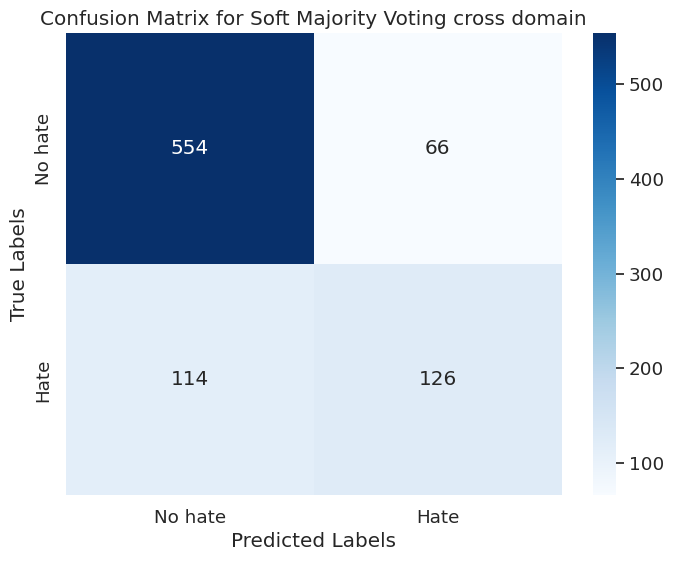

Classification Report for Soft Majority Voting cross domain:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       620
           1       0.66      0.53      0.58       240

    accuracy                           0.79       860
   macro avg       0.74      0.71      0.72       860
weighted avg       0.78      0.79      0.78       860



In [22]:
# Perform Soft Majority Voting cross-domain

cross_soft_majority_prediction = soft_majority_voting([cross_xlnet_probabilities, cross_hateBERT_probabilities, cross_roberta_probabilities])

# Print and plot confusion matrix
print_and_plot_confusion_matrix(OLIDv1_test_df.labels, cross_soft_majority_prediction, "Soft Majority Voting cross domain")

# Print classification report
print_classification_report(OLIDv1_test_df.labels, cross_soft_majority_prediction, "Soft Majority Voting cross domain")

=================
# Stacking ensemble
=================

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [24]:
def count_vect(X_train, X_test):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Transform the text data
    X_train = hstack((vec_word.fit_transform(X_train), vec_char.fit_transform(X_train)))
    X_test = hstack((vec_word.transform(X_test), vec_char.transform(X_test)))

    # Convert X_test to list of comma-separated strings
    temp = [",".join(map(str, row.data)) for row in X_test]

    # Count the number of elements in each row of X_test
    row_counts = X_test.getnnz(axis=1)

    return row_counts

def feature_extraction(X_train, X_test, labels_column, lexicon, column_name=None):
    """
    Perform feature extractionhate frome speech.

    Parameters:
        X_train (pd.Series): Training text data for CountVectorizer.
        X_test (pd.Series): data to extracte feature to.
        labels_column (pd.Series): The column containing the true labels (0 for non-hate, 1 for hate).
        lexicon (pd.DataFrame): The lexicon containing hate speech terms and labels.
        column_name (str): The text column name in the lexicon DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the original text, true labels,
                      normalized negative word count, normalized message length in terms of words,
                      normalized message length in terms of characters, relative number of uppercase characters,
                      relative number of exclamation marks, negative word count,
                      and features from CountVectorizer for both training and test data.
    """
    count_vector = count_vect(X_train,X_test)

    # Create a DataFrame to store results
    results_df = pd.DataFrame({'Text': X_test, 'True_Labels': labels_column})

    # Define a function to count negative words in the text
    def count_negative_words(text, lexicon):
        tokens = text.lower().split()  # Convert to lowercase for case-insensitive matching
        negative_word_count = 0
        for token in tokens:
            if token in lexicon[column_name].values:
                negative_word_count += 1
        return negative_word_count

    # Apply the count_negative_words function to the text data
    results_df['Negative_Word_Count'] = X_test.apply(lambda x: count_negative_words(x, lexicon))

    # Add message length in terms of words
    results_df['Words_Length'] = X_test.apply(lambda x: len(re.findall(r'\w+', x)))

    # Add message length in terms of characters
    results_df['Character_Length'] = X_test.apply(len)

    # Normalize Negative_Word_Count, Words_Length, and Character_Length
    results_df['Normalized_Negative_Word_Count'] = results_df['Negative_Word_Count'] / results_df['Negative_Word_Count'].max()
    results_df['Normalized_Words_Length'] = results_df['Words_Length'] / results_df['Words_Length'].max()
    results_df['Normalized_Character_Length'] = results_df['Character_Length'] / results_df['Character_Length'].max()

    # Add the relative number of uppercase characters in each message
    results_df['Relative_Uppercase_Characters'] = X_test.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

    # Add the relative number of exclamation marks in each message
    results_df['Relative_Exclamation_Marks'] = X_test.apply(lambda x: x.count('!') / len(x) if len(x) > 0 else 0)

    results_df['count_vector'] = count_vector
    results_df['Normalized_count_vector'] = count_vector/max(count_vector)

    return results_df

df = feature_extraction(OLIDv1_train_df['text'], OLIDv1_test_df['text'], OLIDv1_test_df['labels'], lexicon_df, column_name='word')
df.head()


,Text,True_Labels,Negative_Word_Count,Words_Length,Character_Length,Normalized_Negative_Word_Count,Normalized_Words_Length,Normalized_Character_Length,Relative_Uppercase_Characters,Relative_Exclamation_Marks,count_vector,Normalized_count_vector
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1,1,28,245,0.111111,0.430769,0.780255,0.240816,0.012245,225,0.770548
1,"#ConstitutionDay is revered by Conservatives, ...",0,2,15,111,0.222222,0.230769,0.353503,0.054054,0.000000,111,0.380137
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0,0,28,204,0.000000,0.430769,0.649682,0.357843,0.000000,149,0.510274
3,#Watching #Boomer getting the news that she is...,0,0,24,139,0.000000,0.369231,0.442675,0.079137,0.000000,145,0.496575
4,#NoPasaran: Unity demo to oppose the far-right...,1,1,16,98,0.111111,0.246154,0.312102,0.102041,0.010204,95,0.325342


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
[[537  83]
 [ 86 154]]


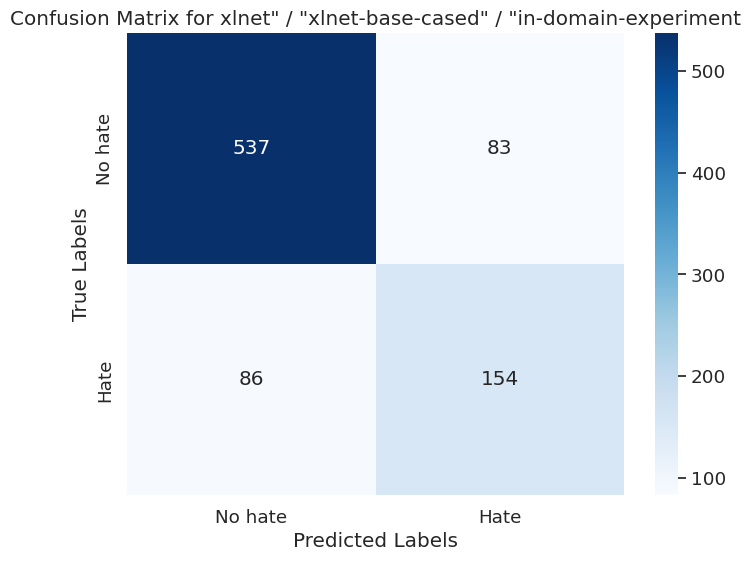

Classification Report for xlnet" / "xlnet-base-cased" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       620
           1       0.65      0.64      0.65       240

    accuracy                           0.80       860
   macro avg       0.76      0.75      0.75       860
weighted avg       0.80      0.80      0.80       860



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
[[554  66]
 [ 98 142]]


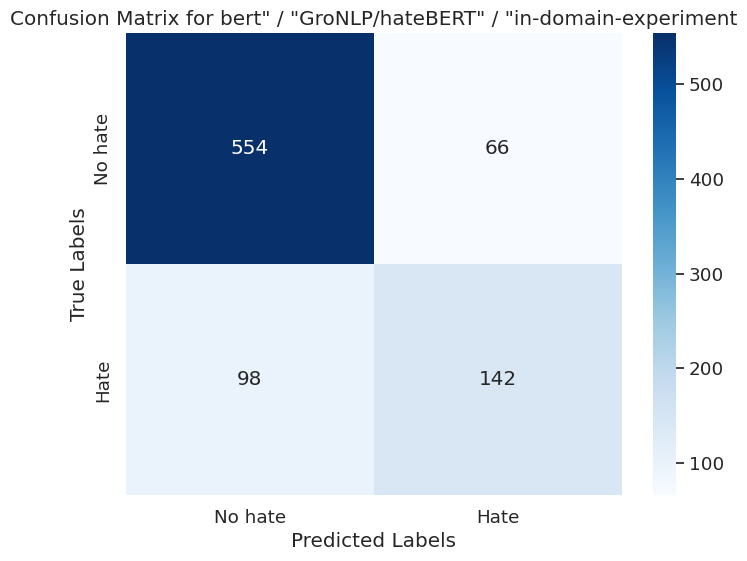

Classification Report for bert" / "GroNLP/hateBERT" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       620
           1       0.68      0.59      0.63       240

    accuracy                           0.81       860
   macro avg       0.77      0.74      0.75       860
weighted avg       0.80      0.81      0.80       860



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "in-domain-experiment:
[[548  72]
 [ 84 156]]


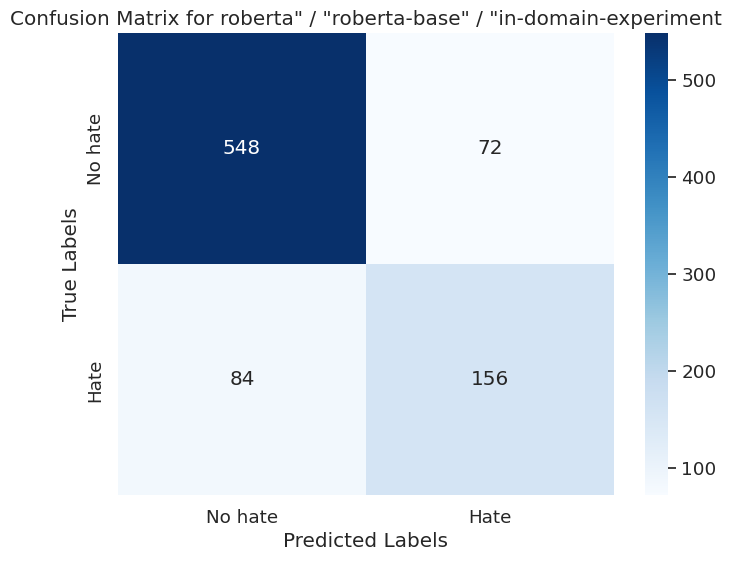

Classification Report for roberta" / "roberta-base" / "in-domain-experiment:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       620
           1       0.68      0.65      0.67       240

    accuracy                           0.82       860
   macro avg       0.78      0.77      0.77       860
weighted avg       0.82      0.82      0.82       860



In [25]:
# Stacking ensemble in-domain
Stacking_xlnet_predictions, Stacking_xlnet_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True, num_folds=5)

Stacking_hateBert_predictions, Stacking_hateBert_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True, num_folds=5)

Stacking_Roberta_predictions, Stacking_Roberta_probabilities = fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True, num_folds=5)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
[[559  61]
 [104 136]]


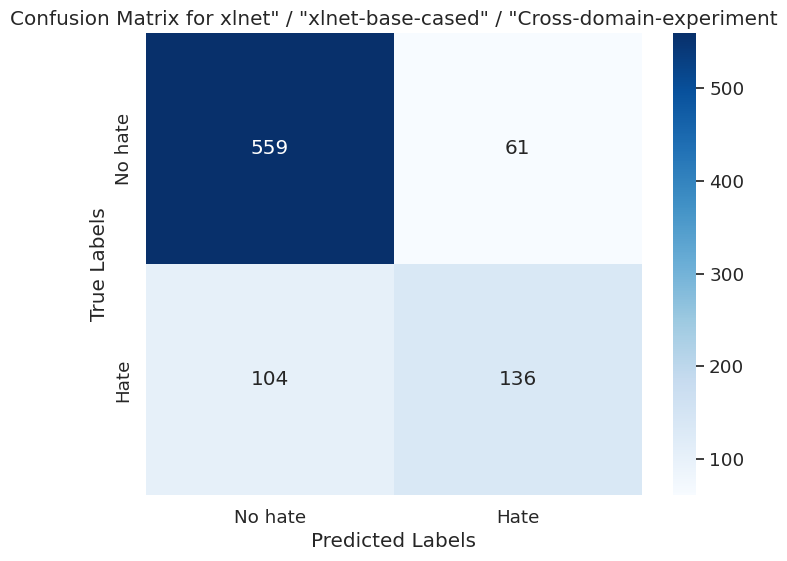

Classification Report for xlnet" / "xlnet-base-cased" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       620
           1       0.69      0.57      0.62       240

    accuracy                           0.81       860
   macro avg       0.77      0.73      0.75       860
weighted avg       0.80      0.81      0.80       860



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
[[499 121]
 [107 133]]


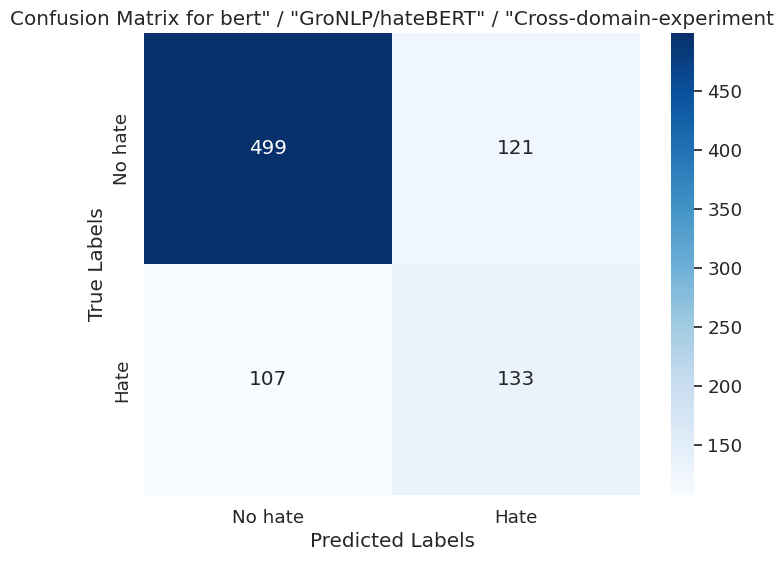

Classification Report for bert" / "GroNLP/hateBERT" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       620
           1       0.52      0.55      0.54       240

    accuracy                           0.73       860
   macro avg       0.67      0.68      0.68       860
weighted avg       0.74      0.73      0.74       860



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3744 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Confusion Matrix for roberta" / "roberta-base" / "Cross-domain-experiment:
[[494 126]
 [ 65 175]]


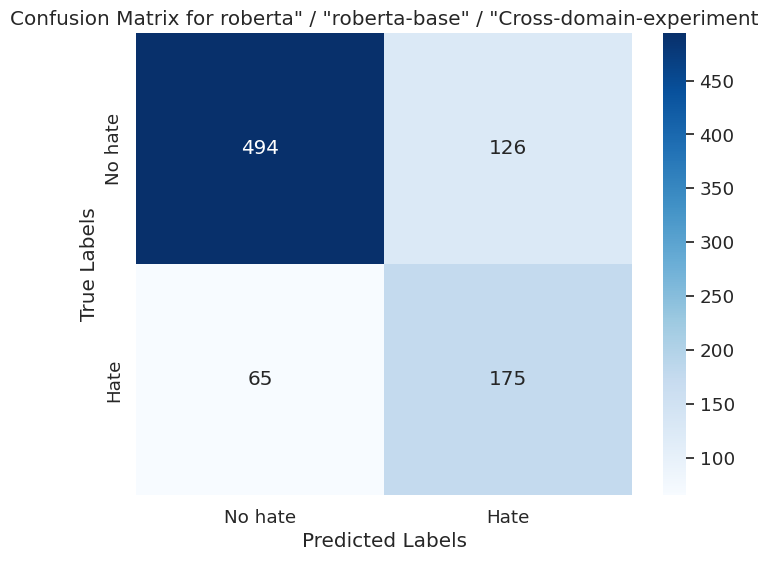

Classification Report for roberta" / "roberta-base" / "Cross-domain-experiment:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       620
           1       0.58      0.73      0.65       240

    accuracy                           0.78       860
   macro avg       0.73      0.76      0.74       860
weighted avg       0.80      0.78      0.78       860



In [26]:
# Stacking ensemble cross-domain
Stacking_cross_xlnet_predictions, Stacking_cross_xlnet_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='xlnet', model_case='xlnet-base-cased', retrain=True, num_folds=5)

Stacking_cross_hateBert_predictions, Stacking_cross_hateBert_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True, num_folds=5)

Stacking_cross_Roberta_predictions, Stacking_cross_Roberta_probabilities = fine_tune_and_evaluate(experiment_name='Cross-domain-experiment',
                        train_dataset=train_hasoc, val_dataset=val_hasoc,
                       test_dataset=OLIDv1_test_df,
                       model_type='roberta', model_case='roberta-base', retrain=True, num_folds=5)

In [28]:
df['Stacking_in_xlnet']=Stacking_xlnet_predictions
df['Stacking_cross_xlnet']=Stacking_cross_xlnet_predictions

df['Stacking_in_hateBert']=Stacking_hateBert_predictions
df['Stacking_cross_hateBert']=Stacking_cross_hateBert_predictions

df['Stacking_in_Roberta']=Stacking_Roberta_predictions
df['Stacking_cross_Roberta']=Stacking_cross_Roberta_predictions

In [34]:
df.head()

,Text,True_Labels,Negative_Word_Count,Words_Length,Character_Length,Normalized_Negative_Word_Count,Normalized_Words_Length,Normalized_Character_Length,Relative_Uppercase_Characters,Relative_Exclamation_Marks,count_vector,Normalized_count_vector,Stacking_in_xlnet,Stacking_cross_xlnet,Stacking_in_hateBert,Stacking_cross_hateBert,Stacking_in_Roberta,Stacking_cross_Roberta
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1,1,28,245,0.111111,0.430769,0.780255,0.240816,0.012245,225,0.770548,1,1,0,1,1,1
1,"#ConstitutionDay is revered by Conservatives, ...",0,2,15,111,0.222222,0.230769,0.353503,0.054054,0.000000,111,0.380137,1,0,0,1,0,0
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0,0,28,204,0.000000,0.430769,0.649682,0.357843,0.000000,149,0.510274,0,0,0,0,0,0
3,#Watching #Boomer getting the news that she is...,0,0,24,139,0.000000,0.369231,0.442675,0.079137,0.000000,145,0.496575,0,0,0,0,0,0
4,#NoPasaran: Unity demo to oppose the far-right...,1,1,16,98,0.111111,0.246154,0.312102,0.102041,0.010204,95,0.325342,0,0,0,0,0,0


In [43]:

def svc_stacking_ensemble(X, y, experiment_name):
    # Splitting the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing the SVC model
    svc_model = SVC(random_state=42)

    # Training the model
    svc_model.fit(X_train, y_train)

    # Making predictions on the test set
    predictions = svc_model.predict(X_test)

    # Printing and plotting confusion matrix
    print_and_plot_confusion_matrix(y_test, predictions, experiment_name)

    # Printing classification report
    print_classification_report(y_test, predictions, experiment_name)

    return svc_model


Confusion Matrix for SVC stacking ensemble in-domain:
[[113  12]
 [ 21  26]]


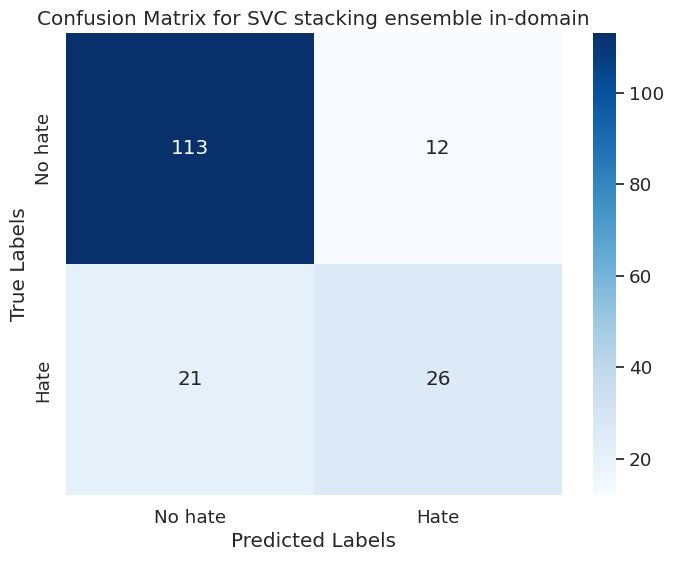

Classification Report for SVC stacking ensemble in-domain:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       125
           1       0.68      0.55      0.61        47

    accuracy                           0.81       172
   macro avg       0.76      0.73      0.74       172
weighted avg       0.80      0.81      0.80       172



In [44]:
# Extracting features (X) and labels (y)
X = df.drop(columns=['True_Labels','Text','Negative_Word_Count','Words_Length','Character_Length','count_vector',
                     'Stacking_cross_Roberta','Stacking_cross_hateBert','Stacking_cross_xlnet'])  # Features
y = df['True_Labels']  # Labels

# Call the function with your features (X) and labels (y) along with the experiment name
svc_model = svc_stacking_ensemble(X, y, "SVC stacking ensemble in-domain")

Confusion Matrix for SVC stacking ensemble cross-domain:
[[117   8]
 [ 21  26]]


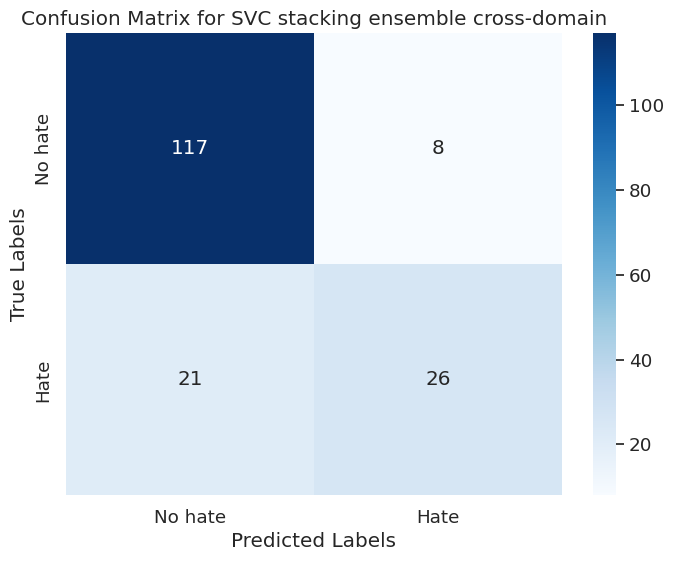

Classification Report for SVC stacking ensemble cross-domain:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       125
           1       0.76      0.55      0.64        47

    accuracy                           0.83       172
   macro avg       0.81      0.74      0.77       172
weighted avg       0.83      0.83      0.82       172



In [45]:
# Extracting features (X) and labels (y)
X = df.drop(columns=['True_Labels','Text','Negative_Word_Count','Words_Length','Character_Length','count_vector',
                     'Stacking_in_Roberta','Stacking_in_hateBert','Stacking_in_xlnet'])  # Features
y = df['True_Labels']  # Labels

# Call the function with your features (X) and labels (y) along with the experiment name
svc_model = svc_stacking_ensemble(X, y, "SVC stacking ensemble cross-domain")

# Discussion performance loss cross-domain

In [ ]:
# The code after this was used for getting insight into the difference in model performance when transitioning from in-domain to cross-domain settings.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load datasets
OLIDv1_train_df = pd.read_csv("olid-train-small.csv")
OLIDv1_test_df = pd.read_csv("olid-test.csv")
HASOC_train_df = pd.read_csv("hasoc-train.csv")

# 1. Length of Messages
OLIDv1_train_df['length'] = OLIDv1_train_df['text'].apply(len)
OLIDv1_test_df['length'] = OLIDv1_test_df['text'].apply(len)
HASOC_train_df['length'] = HASOC_train_df['text'].apply(len)

print("Average length in OLID training data:", OLIDv1_train_df['length'].mean())
print("Average length in OLID test data:", OLIDv1_test_df['length'].mean())
print("Average length in HASOC training data:", HASOC_train_df['length'].mean())

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
# 2. Topical Focus
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import gensim
nltk.download('punkt')

# Preprocess data
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

OLIDv1_train_df['tokens'] = OLIDv1_train_df['text'].apply(preprocess)
OLIDv1_test_df['tokens'] = OLIDv1_test_df['text'].apply(preprocess)
HASOC_train_df['tokens'] = HASOC_train_df['text'].apply(preprocess)

# Create dictionary and corpus for LDA
def generate_lda_topics(data, num_topics=5):
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(text) for text in data]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    return lda.print_topics(-1)

print("Topics in OLID training data:")
topics_olid_train = generate_lda_topics(OLIDv1_train_df['tokens'])
for topic in topics_olid_train:
    print(topic)

print("\nTopics in OLID test data:")
topics_olid_test = generate_lda_topics(OLIDv1_test_df['tokens'])
for topic in topics_olid_test:
    print(topic)

print("\nTopics in HASOC training data:")
topics_hasoc_train = generate_lda_topics(HASOC_train_df['tokens'])
for topic in topics_hasoc_train:
    print(topic)

In [ ]:
import pandas as pd

# Load datasets
OLIDv1_train_df = pd.read_csv("olid-train.csv")
OLIDv1_test_df = pd.read_csv("olid-test.csv")
HASOC_train_df = pd.read_csv("hasoc-train.csv")

# Extract unique words from each dataset
OLID_train_words = set(" ".join(OLIDv1_train_df['text']).split())
OLID_test_words = set(" ".join(OLIDv1_test_df['text']).split())
HASOC_train_words = set(" ".join(HASOC_train_df['text']).split())

# Words in OLID test set but not in OLID train set
missing_words_in_domain = OLID_test_words - OLID_train_words

# Words in OLID test set but not in HASOC train set
missing_words_cross_domain = OLID_test_words - HASOC_train_words

print(f"Number of words in OLID test set not seen in OLID train set: {len(missing_words_in_domain)}")
print(f"Number of words in OLID test set not seen in HASOC train set: {len(missing_words_cross_domain)}")